<a href="https://colab.research.google.com/github/kshen3778/GAN-Failure-Monitor/blob/master/NBD_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- low standard devation of NBD score during training = model is not training properly
- high NBD score = mode collapse

how to determine what is a "high" score: need to run experiments to determine reasonable threshold for certain type of well-known GANs or let it be user defined. User defined seems easiest and good for a first prototype.

NDB score measure diversity of generated samples with respect to training samples.

Visualizing the bins should be an important aspect of the final library

v1
1. Pick DCGAN (Pytorch) and a dataset (CelebA) and integrate NBD in a stable version (Log the NBD scores using weights and biases) - Show generated images
2. Modify the GAN so it has mode collapse, then show the result - Show generated images
3. Show bins (if possible)

v2
1. Pick multiple GANs and repeat all 3 steps in v1

In [0]:
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
from matplotlib import pyplot as plt
import pickle as pkl

class NDB:
    def __init__(self, training_data=None, number_of_bins=100, significance_level=0.05, z_threshold=None,
                 whitening=False, max_dims=None, cache_folder=None):
        """
        NDB Evaluation Class
        :param training_data: Optional - the training samples - array of m x d floats (m samples of dimension d)
        :param number_of_bins: Number of bins (clusters) default=100
        :param significance_level: The statistical significance level for the two-sample test
        :param z_threshold: Allow defining a threshold in terms of difference/SE for defining a bin as statistically different
        :param whitening: Perform data whitening - subtract mean and divide by per-dimension std
        :param max_dims: Max dimensions to use in K-means. By default derived automatically from d
        :param bins_file: Optional - file to write / read-from the clusters (to avoid re-calculation)
        """
        self.number_of_bins = number_of_bins
        self.significance_level = significance_level
        self.z_threshold = z_threshold
        self.whitening = whitening
        self.ndb_eps = 1e-6
        self.training_mean = 0.0
        self.training_std = 1.0
        self.max_dims = max_dims
        self.cache_folder = cache_folder
        self.bin_centers = None
        self.bin_proportions = None
        self.ref_sample_size = None
        self.used_d_indices = None
        self.results_file = None
        self.test_name = 'ndb_{}_bins_{}'.format(self.number_of_bins, 'whiten' if self.whitening else 'orig')
        self.cached_results = {}
        if self.cache_folder:
            self.results_file = os.path.join(cache_folder, self.test_name+'_results.pkl')
            if os.path.isfile(self.results_file):
                # print('Loading previous results from', self.results_file, ':')
                self.cached_results = pkl.load(open(self.results_file, 'rb'))
                # print(self.cached_results.keys())
        if training_data is not None or cache_folder is not None:
                bins_file = None
                if cache_folder:
                    os.makedirs(cache_folder, exist_ok=True)
                    bins_file = os.path.join(cache_folder, self.test_name+'.pkl')
                self.construct_bins(training_data, bins_file)

    def construct_bins(self, training_samples, bins_file):
        """
        Performs K-means clustering of the training samples
        :param training_samples: An array of m x d floats (m samples of dimension d)
        """

        if self.__read_from_bins_file(bins_file):
            return
        n, d = training_samples.shape
        k = self.number_of_bins
        if self.whitening:
            self.training_mean = np.mean(training_samples, axis=0)
            self.training_std = np.std(training_samples, axis=0) + self.ndb_eps

        if self.max_dims is None and d > 1000:
            # To ran faster, perform binning on sampled data dimension (i.e. don't use all channels of all pixels)
            self.max_dims = d//6

        whitened_samples = (training_samples-self.training_mean)/self.training_std
        d_used = d if self.max_dims is None else min(d, self.max_dims)
        self.used_d_indices = np.random.choice(d, d_used, replace=False)

        print('Performing K-Means clustering of {} samples in dimension {} / {} to {} clusters ...'.format(n, d_used, d, k))
        print('Can take a couple of minutes...')
        if n//k > 1000:
            print('Training data size should be ~500 times the number of bins (for reasonable speed and accuracy)')

        clusters = KMeans(n_clusters=k, max_iter=100, n_jobs=-1).fit(whitened_samples[:, self.used_d_indices])

        bin_centers = np.zeros([k, d])
        for i in range(k):
            bin_centers[i, :] = np.mean(whitened_samples[clusters.labels_ == i, :], axis=0)

        # Organize bins by size
        label_vals, label_counts = np.unique(clusters.labels_, return_counts=True)
        bin_order = np.argsort(-label_counts)
        self.bin_proportions = label_counts[bin_order] / np.sum(label_counts)
        self.bin_centers = bin_centers[bin_order, :]
        self.ref_sample_size = n
        self.__write_to_bins_file(bins_file)
        print('Done.')

    def evaluate(self, query_samples, model_label=None):
        """
        Assign each sample to the nearest bin center (in L2). Pre-whiten if required. and calculate the NDB
        (Number of statistically Different Bins) and JS divergence scores.
        :param query_samples: An array of m x d floats (m samples of dimension d)
        :param model_label: optional label string for the evaluated model, allows plotting results of multiple models
        :return: results dictionary containing NDB and JS scores and array of labels (assigned bin for each query sample)
        """
        n = query_samples.shape[0]
        query_bin_proportions, query_bin_assignments = self.__calculate_bin_proportions(query_samples)
        # print(query_bin_proportions)
        different_bins = NDB.two_proportions_z_test(self.bin_proportions, self.ref_sample_size, query_bin_proportions,
                                                    n, significance_level=self.significance_level,
                                                    z_threshold=self.z_threshold)
        ndb = np.count_nonzero(different_bins)
        js = NDB.jensen_shannon_divergence(self.bin_proportions, query_bin_proportions)
        results = {'NDB': ndb,
                   'JS': js,
                   'Proportions': query_bin_proportions,
                   'N': n,
                   'Bin-Assignment': query_bin_assignments,
                   'Different-Bins': different_bins}

        if model_label:
            print('Results for {} samples from {}: '.format(n, model_label), end='')
            self.cached_results[model_label] = results
            if self.results_file:
                # print('Storing result to', self.results_file)
                pkl.dump(self.cached_results, open(self.results_file, 'wb'))

        print('NDB =', ndb, 'NDB/K =', ndb/self.number_of_bins, ', JS =', js)
        return results

    def print_results(self):
        print('NSB results (K={}{}):'.format(self.number_of_bins, ', data whitening' if self.whitening else ''))
        for model in sorted(list(self.cached_results.keys())):
            res = self.cached_results[model]
            print('%s: NDB = %d, NDB/K = %.3f, JS = %.4f' % (model, res['NDB'], res['NDB']/self.number_of_bins, res['JS']))

    def plot_results(self, models_to_plot=None):
        """
        Plot the binning proportions of different methods
        :param models_to_plot: optional list of model labels to plot
        """
        K = self.number_of_bins
        w = 1.0 / (len(self.cached_results)+1)
        assert K == self.bin_proportions.size
        assert self.cached_results

        # Used for plotting only
        def calc_se(p1, n1, p2, n2):
            p = (p1 * n1 + p2 * n2) / (n1 + n2)
            return np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

        if not models_to_plot:
            models_to_plot = sorted(list(self.cached_results.keys()))

        # Visualize the standard errors using the train proportions and size and query sample size
        train_se = calc_se(self.bin_proportions, self.ref_sample_size,
                           self.bin_proportions, self.cached_results[models_to_plot[0]]['N'])
        plt.bar(np.arange(0, K)+0.5, height=train_se*2.0, bottom=self.bin_proportions-train_se,
                width=1.0, label='Train$\pm$SE', color='gray')

        ymax = 0.0
        for i, model in enumerate(models_to_plot):
            results = self.cached_results[model]
            label = '%s (%i : %.4f)' % (model, results['NDB'], results['JS'])
            ymax = max(ymax, np.max(results['Proportions']))
            if K <= 70:
                plt.bar(np.arange(0, K)+(i+1.0)*w, results['Proportions'], width=w, label=label)
            else:
                plt.plot(np.arange(0, K)+0.5, results['Proportions'], '--*', label=label)
        plt.legend(loc='best')
        plt.ylim((0.0, min(ymax, np.max(self.bin_proportions)*4.0)))
        plt.grid(True)
        plt.title('Binning Proportions Evaluation Results for {} bins (NDB : JS)'.format(K))
        plt.show()

    def __calculate_bin_proportions(self, samples):
        if self.bin_centers is None:
            print('First run construct_bins on samples from the reference training data')
        assert samples.shape[1] == self.bin_centers.shape[1]
        n, d = samples.shape
        k = self.bin_centers.shape[0]
        D = np.zeros([n, k], dtype=samples.dtype)

        print('Calculating bin assignments for {} samples...'.format(n))
        whitened_samples = (samples-self.training_mean)/self.training_std
        for i in range(k):
            print('.', end='', flush=True)
            D[:, i] = np.linalg.norm(whitened_samples[:, self.used_d_indices] - self.bin_centers[i, self.used_d_indices],
                                     ord=2, axis=1)
        print()
        labels = np.argmin(D, axis=1)
        probs = np.zeros([k])
        label_vals, label_counts = np.unique(labels, return_counts=True)
        probs[label_vals] = label_counts / n
        return probs, labels

    def __read_from_bins_file(self, bins_file):
        if bins_file and os.path.isfile(bins_file):
            print('Loading binning results from', bins_file)
            bins_data = pkl.load(open(bins_file,'rb'))
            self.bin_proportions = bins_data['proportions']
            self.bin_centers = bins_data['centers']
            self.ref_sample_size = bins_data['n']
            self.training_mean = bins_data['mean']
            self.training_std = bins_data['std']
            self.used_d_indices = bins_data['d_indices']
            return True
        return False

    def __write_to_bins_file(self, bins_file):
        if bins_file:
            print('Caching binning results to', bins_file)
            bins_data = {'proportions': self.bin_proportions,
                         'centers': self.bin_centers,
                         'n': self.ref_sample_size,
                         'mean': self.training_mean,
                         'std': self.training_std,
                         'd_indices': self.used_d_indices}
            pkl.dump(bins_data, open(bins_file, 'wb'))

    @staticmethod
    def two_proportions_z_test(p1, n1, p2, n2, significance_level, z_threshold=None):
        # Per http://stattrek.com/hypothesis-test/difference-in-proportions.aspx
        # See also http://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/binotest.htm
        p = (p1 * n1 + p2 * n2) / (n1 + n2)
        se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
        z = (p1 - p2) / se
        # Allow defining a threshold in terms as Z (difference relative to the SE) rather than in p-values.
        if z_threshold is not None:
            return abs(z) > z_threshold
        p_values = 2.0 * norm.cdf(-1.0 * np.abs(z))    # Two-tailed test
        return p_values < significance_level

    @staticmethod
    def jensen_shannon_divergence(p, q):
        """
        Calculates the symmetric Jensen–Shannon divergence between the two PDFs
        """
        m = (p + q) * 0.5
        return 0.5 * (NDB.kl_divergence(p, m) + NDB.kl_divergence(q, m))

    @staticmethod
    def kl_divergence(p, q):
        """
        The Kullback–Leibler divergence.
        Defined only if q != 0 whenever p != 0.
        """
        assert np.all(np.isfinite(p))
        assert np.all(np.isfinite(q))
        assert not np.any(np.logical_and(p != 0, q == 0))

        p_pos = (p > 0)
        return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))





In [0]:
def test_ndb():  
  dim=100
  k=100
  n_train = k*100
  n_test = k*10

  train_samples = np.random.uniform(size=[n_train, dim])
  ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)

  test_samples = np.random.uniform(high=1.0, size=[n_test, dim])
  results = ndb.evaluate(test_samples, model_label='Test')
  print(results['Bin-Assignment'])

  # test_samples = np.random.uniform(high=0.9, size=[n_test, dim])
  # ndb.evaluate(test_samples, model_label='Good')

  # test_samples = np.random.uniform(high=0.75, size=[n_test, dim])
  # ndb.evaluate(test_samples, model_label='Bad')

  # ndb.plot_results(models_to_plot=['Test', 'Good', 'Bad'])

In [3]:
test_ndb()

Performing K-Means clustering of 10000 samples in dimension 100 / 100 to 100 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1000 samples...
....................................................................................................
Results for 1000 samples from Test: NDB = 1 NDB/K = 0.01 , JS = 0.01109149683758622
[46 72 39 44 50 50 72  5  7 83 73 42 48  8 79 22 44 10  2 20 60 24 49 26
 30  6  7 83 62 56 82 13 68 49 74 95 51 61  3 72  3 89 16  0 61 91 74 23
 57 29 67 73 26 87 34 62 73 20 70 85 11 69 59  4 92 96  5 25 13 26  2 33
 32 79  0 59 21 22 25 46  4 35 53 94 99 37 46 40 41 33 74  8 57 44 11 23
 91 41 70 29 18 28 80 65 26 64 36 31 55  1 86  1  3 45 14 52 48 40 77 83
 69 31 85 59 64 88 43 56 36 70 96 20 21 98 56 29 25 71  9 91 19 42 25 17
 42 23 32  4 46 33 85 44  2 63 55 64 44 36 58 67 78  4 85 32 16 53 32  2
 75 93 24  4 65 16 64 65 14  2 24 90  9 45 33 18 24 45 55 46 84 41 33 46
 67 29 75 54 25 88  9 49 72 38 43 19 63 85 47  8 56 76 

In [0]:

# gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

#define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
#Original: 100 epochs, 256 batch size
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):

  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d_loss_arr = []
  g_loss_arr = []
  acc_arr = []

  k=100
  dim=784
  train_size = 60000
  test_size = 6000

  train_samples = dataset.reshape(train_size, dim)
  ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)
  ndb_scores = []
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, acc = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      d_loss_arr.append(d_loss)
      g_loss_arr.append(g_loss)
      acc_arr.append(acc)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 1 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, test_size)
      test_samples = X_fake.reshape(test_size, dim)
      results = ndb.evaluate(test_samples)
      ndb_scores.append(results["NDB"])
      print("NDB Scores: ", ndb_scores)
  return d_loss_arr, g_loss_arr, acc_arr, ndb_scores


Using TensorFlow backend.


In [0]:
# size of the latent space
latent_dim = 1
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
d_good,g_good,acc_good, ndb_scores = train(g_model, d_model, gan_model, dataset, latent_dim)

11493376/11490434 [==============================] - 1s 0us/step
Performing K-Means clustering of 60000 samples in dimension 784 / 784 to 100 clusters ...
Can take a couple of minutes...
Done.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>80, 21/234, d=0.565, g=1.084
>80, 22/234, d=0.560, g=1.136
>80, 23/234, d=0.534, g=1.198
>80, 24/234, d=0.530, g=1.163
>80, 25/234, d=0.607, g=1.275
>80, 26/234, d=0.574, g=1.151
>80, 27/234, d=0.622, g=1.036
>80, 28/234, d=0.585, g=1.202
>80, 29/234, d=0.585, g=1.119
>80, 30/234, d=0.565, g=1.084
>80, 31/234, d=0.598, g=1.020
>80, 32/234, d=0.565, g=1.072
>80, 33/234, d=0.653, g=1.108
>80, 34/234, d=0.601, g=0.998
>80, 35/234, d=0.574, g=1.090
>80, 36/234, d=0.591, g=1.116
>80, 37/234, d=0.579, g=1.195
>80, 38/234, d=0.592, g=1.180
>80, 39/234, d=0.539, g=1.139
>80, 40/234, d=0.545, g=1.169
>80, 41/234, d=0.581, g=1.072
>80, 42/234, d=0.546, g=1.061
>80, 43/234, d=0.552, g=1.229
>80, 44/234, d=0.515, g=1.223
>80, 45/234, d=0.561, g=1.231
>80, 46/234, d=0.581, g=1.167
>80, 47/234, d=0.582, g=1.158
>80, 48/234, d=0.621, g=1.070
>80, 49/234, d=0.528, g=1.025
>80, 50/234, d=0.549, g=1.165
>80, 51/234, d=0.543, g=1.163
>80, 52/234, d=0.52

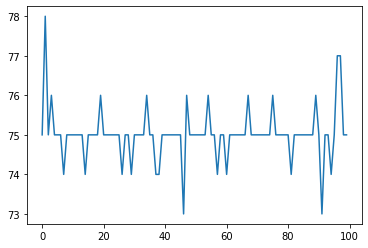

In [0]:
import matplotlib.pyplot as plt
plt.plot(ndb_scores)

#Need to test on mode collapse - the original purpose of this metric

In [0]:
# Unstable GAN - Convergence Failure
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from matplotlib import pyplot

#Convergence Failure GAN

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

  

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# select all of the examples for a given class
	selected_ix = trainy == 8
	X = X[selected_ix]
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	pyplot.savefig('results_convergence/generated_plot_%03d.png' % (step+1))
	pyplot.close()
	# save the generator model
	g_model.save('results_convergence/model_%03d.h5' % (step+1))

# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, a_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d_hist, label='dis')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a_hist, label='acc')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('results_convergence/plot_line_plot_loss.png')

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=128):

    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d_hist, g_hist, a_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # combine into one batch
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, d_acc = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, d=%.3f, g=%.3f, a=%d' % (i+1, d_loss, g_loss, int(100*d_acc)))
      # record history
      d_hist.append(d_loss)
      g_hist.append(g_loss)
      a_hist.append(d_acc)
      # evaluate the model performance every 'epoch'
      if (i+1) % bat_per_epo == 0:
        summarize_performance(i, g_model, latent_dim)
    plot_history(d_hist, g_hist, a_hist)
    return d_hist, g_hist, a_hist

# make folder for results
makedirs('results_convergence', exist_ok=True)
# size of the latent space
latent_dim = 50
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
d_bad,g_bad,acc_bad = train(generator, discriminator, gan_model, dataset, latent_dim)

(5851, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d=1.329, g=0.720, a=3
>2, d=0.546, g=0.604, a=95
>3, d=0.291, g=0.426, a=99
>4, d=0.186, g=0.351, a=99
>5, d=0.109, g=0.260, a=100
>6, d=0.074, g=0.191, a=100
>7, d=0.059, g=0.143, a=100
>8, d=0.049, g=0.128, a=100
>9, d=0.039, g=0.113, a=100
>10, d=0.034, g=0.087, a=100
>11, d=0.034, g=0.076, a=100
>12, d=0.029, g=0.063, a=100
>13, d=0.024, g=0.057, a=100
>14, d=0.022, g=0.054, a=100
>15, d=0.022, g=0.045, a=100
>16, d=0.016, g=0.039, a=100
>17, d=0.017, g=0.038, a=100
>18, d=0.017, g=0.037, a=100
>19, d=0.014, g=0.031, a=100
>20, d=0.015, g=0.030, a=100
>21, d=0.014, g=0.029, a=100
>22, d=0.014, g=0.028, a=100
>23, d=0.012, g=0.025, a=100
>24, d=0.012, g=0.021, a=100
>25, d=0.010, g=0.024, a=100
>26, d=0.011, g=0.022, a=100
>27, d=0.010, g=0.020, a=100
>28, d=0.008, g=0.019, a=100
>29, d=0.009, g=0.017, a=100
>30, d=0.009, g=0.017, a=100
>31, d=0.007, g=0.015, a=100
>32, d=0.008, g=0.017, a=100
>33, d=0.008, g=0.015, a=100
>34, d=0.007, g=0.015, a=100
>35, d=0.006, g=0.013, a=100

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7efc41a10598> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
k=100
dim=784
train_size = 5851
test_size = 580

In [0]:
train_samples = load_real_samples()
train_samples = train_samples.reshape(train_size, dim)
train_samples.shape

(5851, 784)

In [0]:
test_samples = generate_fake_samples(generator, latent_dim, test_size)
test_samples = test_samples[0].reshape(test_size, dim)
test_samples.shape

(580, 784)

Performing K-Means clustering of 5851 samples in dimension 784 / 784 to 100 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 580 samples...
....................................................................................................
Results for 580 samples from Test: NDB = 49 NDB/K = 0.49 , JS = 0.6165076005694067


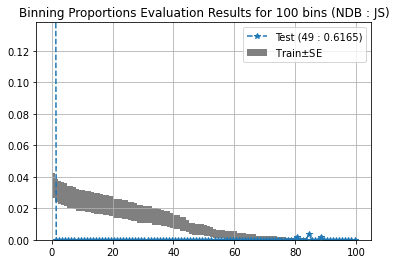

In [0]:
#Test on Mnist
ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)
ndb.evaluate(test_samples, model_label='Test')
ndb.plot_results(models_to_plot=['Test'])